# Задание 1: ЭЭГ и FFT

При закрытии глаз у приблизительно 90% людей на электроэнцефалограмме (ЭЭГ) увеличивается амплитуда гармоник, лежащих в диапазоне от 8 до 12 Гц (альфа-ритм).

В приложенном файле (input.txt) находятся два отрывка сигнала ЭЭГ, записанных с одного канала во время одной и той же сессии при открытых и закрытых глазах. Известно, что у испытуемого наблюдается усиление альфа-ритма при закрытии глаз.
Напишите программу, которая определяет, какой из двух отрывков был записан с закрытыми глазами.

Частота оцифровки сигнала 128 Гц. Каждый отрезок сигнала представлен последовательностью действительных чисел, разделённых пробелом. Отрезки разделены символом переноса на новую строку. Программа должна вывести 1 или 2 - номер строки, отрывок энцефалограммы которой имеет большую мощность альфа-ритма.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
eeg = []
with open('input.txt', 'r') as f:
    for line in f:
        eeg.append(np.array(list(map(float, line.split(',')))))

    for session in eeg:
        print(session.mean())
        print(session.size)

65.97561
1000
29.021279999999997
1000


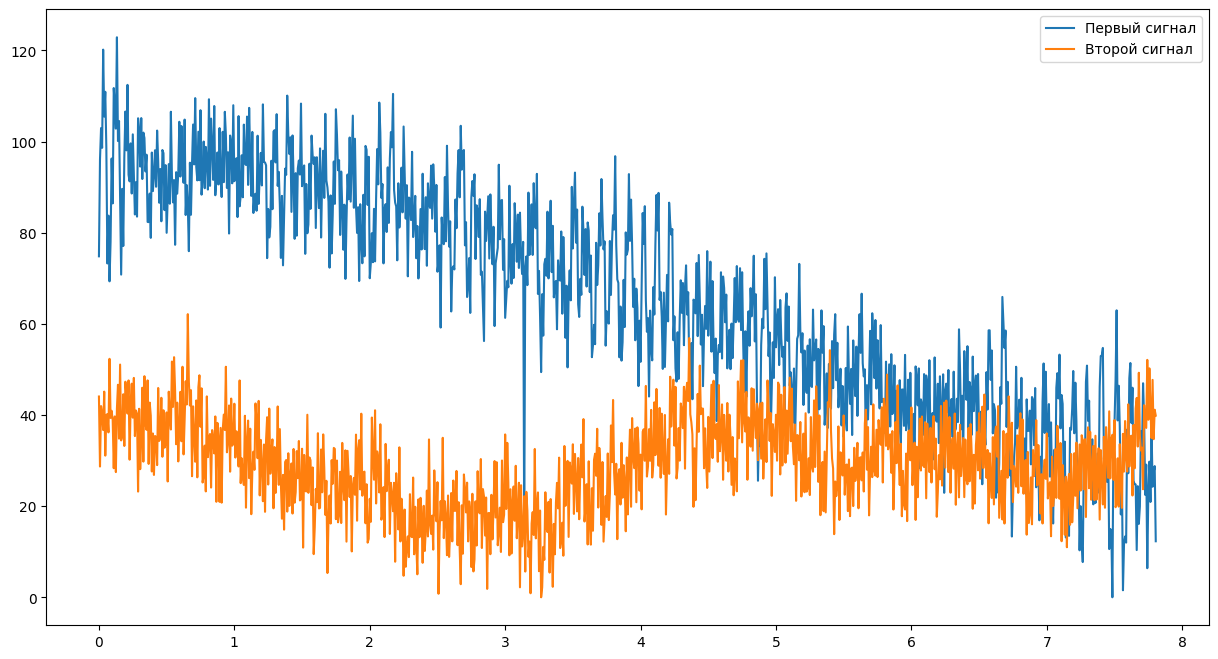

In [31]:
t_data = np.arange(0, 1000) * (1/128)

plt.figure(figsize=(15, 8))

plt.plot(t_data, eeg[0], label="Первый сигнал")
plt.plot(t_data, eeg[1], label="Второй сигнал")
plt.legend()

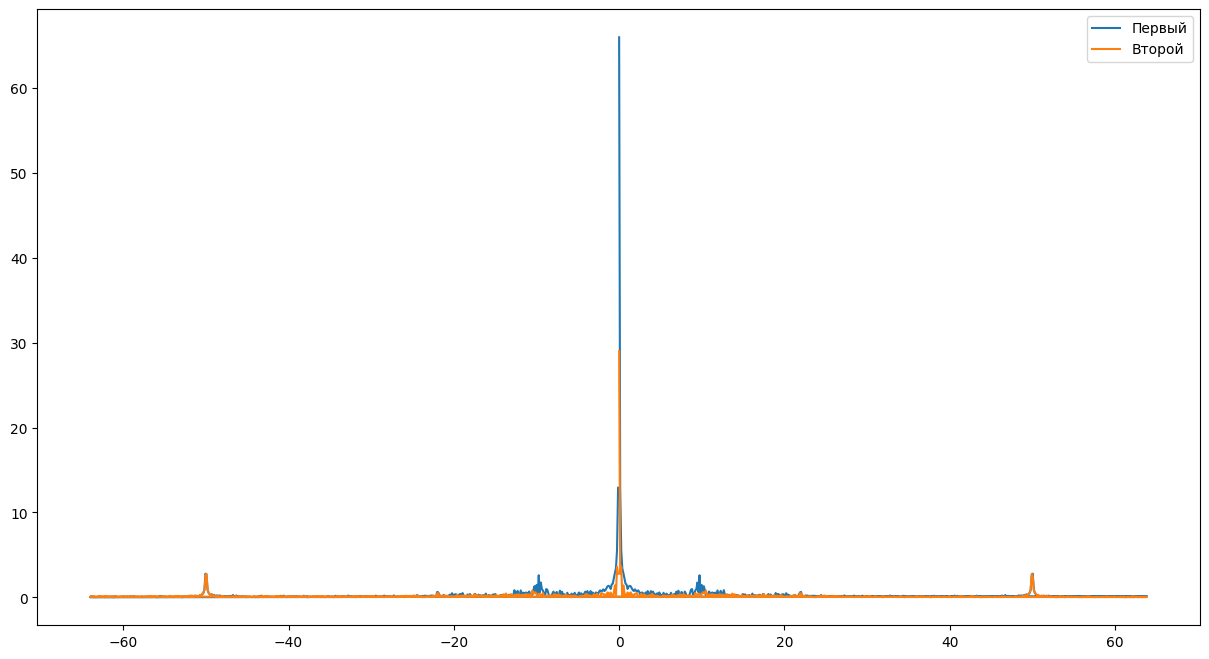

In [61]:
fourier_1=np.abs(np.fft.fft(eeg[0])/1000)
fourier_2=np.abs(np.fft.fft(eeg[1])/1000)
fourier_x = np.fft.fftfreq( 1000, 1 / 128.0)
plt.figure(figsize=(15,8))
plt.plot(fourier_x, fourier_1, label="Первый")
plt.plot(fourier_x, fourier_2, label="Второй")
plt.legend()

# Задание 2: Numba и WAV

### Волновое уравнение (базовое)

$$\large \frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2} \frac{\partial^2 y}{\partial t^2} = 0$$

### Полноценное (можно имитировать гитарные струны) уравнение

$$\large \frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2} \frac{\partial^2 y}{\partial t^2} -\gamma \frac{\partial y}{\partial t} - l^2 \frac{\partial^4 y}{\partial x^4} = 0$$

при 


$$y(0, t) = y(L, t) = 0, y(x, 0) = f(x)$$

$y -$ амплитуда струны, $x -$ положение струны, $t -$ время.

Параметры:
* $c - $ скорость волны ($\frac{\text{м}}{\text{сек}}$)
* $\gamma - $ постоянная демпфирования ($\frac{\text{сек}}{\text{м}}$)
* $l - $ коэффициент жесткости (характеристическая длина).

Дискретная форма:

$$\frac{y_{j+1}^{m} -2y_{j}^{m} + y_{j-1}^{m}}{\Delta x^2} - \frac{1}{c^2} \frac{y_{j}^{m+1} -2y_{j}^{m} + y_{j}^{m-1}}{\Delta t^2} - \gamma \frac{y_{j}^{m+1} - y_{j}^{m-1}}{2\Delta t} - l^2 \frac{y_{j-2}^{m} - 4y_{j-1}^{m} + 6y_{j}^{m} - 4y_{j+1}^{m} + y_{j+2}^{m}}{\Delta x^4} = 0$$

Найти $y_{j}^{m + 1} -$ амплитуду струны в следующий ($(m+1)$-й) момент времени:

$$y_{j}^{m+1} = \bigg[\frac{1}{c^{2}\Delta t^2} + \frac{\gamma}{2\Delta t} \bigg]^{-1}\bigg[\frac{1}{\Delta x^2}(y_{j+1}^{m} -2y_{j}^{m} + y_{j-1}^{m}) - \frac{1}{c^{2}\Delta t^2}(y_{j}^{m+1} - y_{j}^{m-1}) + \frac{\gamma}{2\Delta t} y_{j}^{m-1} - \frac{l^2}{\Delta x^4} (y_{j-2}^{m} - 4y_{j-1}^{m} + 6y_{j}^{m} - 4y_{j+1}^{m} + y_{j+2}^{m})
\bigg]$$

Для устойчивости необходимо $\frac{c\Delta t}{\Delta x} < 1$.

## Решение

* Длина гитарной струны $L = 0.7$ м
* $\Delta x = 0.7$ мм, то есть $N_{x} = 101$ положений гитарной струны
* Фундаментальная частота гитарной ноты $f = \frac{c}{2L}$. Ноте "Ля" малой октавы соответствует частота $220$ Hz и  скорость волны $c = 308$ м/c <br>
($f \cdot 2 \cdot L = 220 \cdot 2 \cdot 0.7 = 308$) <a href="https://www.physicsclassroom.com/class/sound/Lesson-5/Guitar-Strings"> Детали</a>
* Для устойчивости выбираем $\Delta t = 5 \times 10^{-6}$ сек. Чтобы в результате было минимум несколько секунд, выбираем $N_{t} = 500\_000$ 
* $l = 2 \times 10^{-6}$, $\gamma = 2.6 \times 10^{-5} \frac{\text{сек}}{\text{м}}$

In [55]:
Nx = 101
Nt = 500000
dx = 7*10**(-3)
dt = 5*10**(-6)
c = 308
l = 2*10**(-6)
gamma = 2.6*10**(-5)

Проинициализируйте начальное состояние струны


![oops](y0.png)

```python
y0 = ...
```

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [46]:
y0 =  np.zeros(101)
x  = np.linspace(0, 100, Nx)
y0[0:70] = (0.01 / 70) * x[0:70]
y0[70:100] = - (0.01 / 30) * (x[70:100] - 70) + 0.01

Постройте график $y_{0}$ от $t$ с соотношением сторон 5 к 1

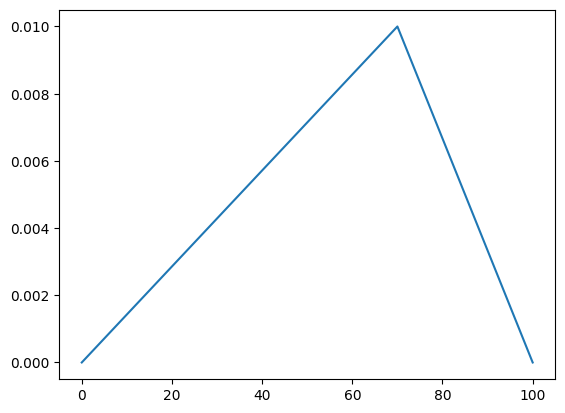

In [47]:
plt.plot(y0)
plt.show()

Создайте двумерный массив $y(x, t)$ и заполните его нулями.

In [49]:
sol =  np.zeros((Nx, Nt))

Проинициализируйте $y_{0}$ 

In [85]:
for i in range(Nx-1):
    sol[i][0]=y0[i]

### Напишите с помощью Numba функцию, которая высчитывает $y$

In [98]:
def compute(sol, Nt, Nx , dt, dx, c,l,gamma):
  c1 = 1 / (1 / (c**2 * dt**2) + gamma / (2 *dt))
  c2 = 1 / dx**2
  c3 = 1 / (c**2 * dt**2)
  c4= gamma / (2*dt)
  c5= l**2 / dx**4
  for i in range(1, Nt-1):
    for j in range(2, Nx-2):
      sol[j][i + 1] = c1*(c2*(sol[j+1][i]-2*sol[j][i]+sol[j-1][i])
                      -c3*(sol[j][i-1]-2*sol[j][i])+c4*sol[j][i-1]
                      -c5*(sol[j-2][i]-4*sol[j-1][i]+6*sol[j][i]
                           -4*sol[j+1][i]+sol[j+2][i]))
  return sol

In [99]:
from numba import njit
numba_compute = njit(compute)

In [100]:
sol = numba_compute(sol, Nt, Nx, dt, dx, c,l,gamma)

In [101]:
sol

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.42857143e-04, 1.42857143e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.85714286e-04, 2.85714286e-04, 2.85714286e-04, ...,
        2.10767834e-06, 1.33313963e-06, 4.81352521e-07],
       ...,
       [6.66666667e-04, 6.66666667e-04, 6.66666667e-04, ...,
        7.26782773e-06, 6.29239466e-06, 5.35140767e-06],
       [3.33333333e-04, 3.33333333e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

постройте некоторые положения струны

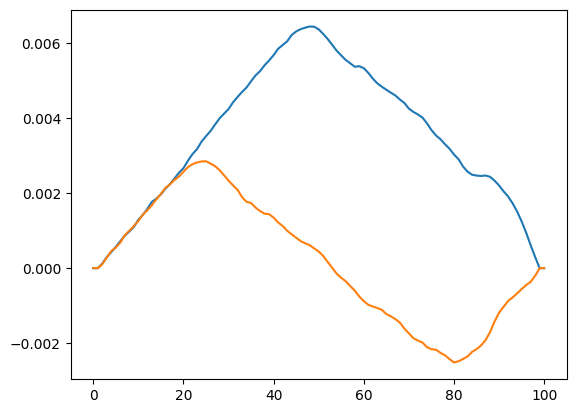

In [102]:
plt.plot(sol[:,1000])
plt.plot(sol[:,2000])

### Создайте анимацию

Одна секунда это $\frac{1}{dt}$ кадров (fps)

Если взять каждый 10-й кадр, то fps уменьшится в 10 раз. 

В нашей задаче $\Delta t = 5\times 10^{-6} \Rightarrow 200000$ fps

Если у gif-файла указать fps 20, то анимация будет в 1000 раз медленнее реальной

У
```python
animation.FuncAnimation()
```

обратите внимание на аргументы ```frames``` и ```interval```

У метода ```save``` обратите внимание на ```writer``` и ```fps```

In [131]:
import matplotlib.animation as animation
!pip3 install ffmpeg
!pip3 install yasm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


RuntimeError: Requested MovieWriter (ffmpeg) not available

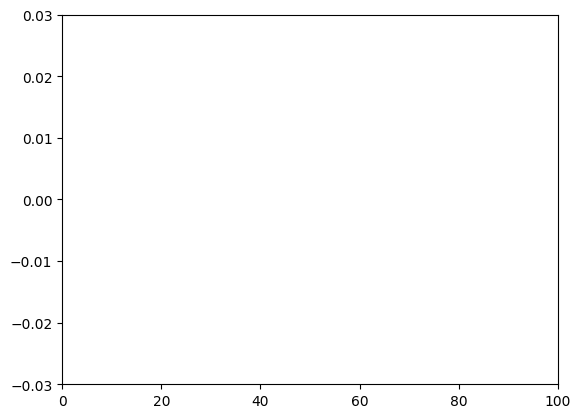

In [180]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation


fig, ax = plt.subplots()

ax.set_xlim((0, 100))
ax.set_ylim((-0.03, 0.03))

line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return (line,)

def animate(i):
  y = sol[:,i]
  line.set_data(x, y)
  return (line,)

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Wav Spectrogram', artist='Matplotlib', comment='')

anime = animation.FuncAnimation(fig, animate, init_func=init, frames=1000, interval=20, blit=True)

anime = anime.save(writer=FFMpegWriter, fps=1000)
anime

<module 'ffmpeg._ffmpeg' from '/Users/eldarst/Library/Python/3.9/lib/python/site-packages/ffmpeg/_ffmpeg.py'>

## Создать музыкальный файл .WAV

Извлечь "количество" гармоник в любой момент времени $t$ можно по формуле

$$\int_{0}^{L} y(x, t) \sin(\frac{n\pi x}{L})dx$$

$n~-$ номер гармоники.

In [174]:
def integral(j):
    y=sol[:,j]
    n = 10
    def count(i):
        return (y[i]+y[i+1]) *(np.sin(n*np.pi*7e-3*i/0.7) +np.sin(n*np.pi*7e-3*(i+1)/0.7))/4
    return sum(count(i) for i in range(Nx-1))

harm = []
for j in range(Nt):
    res = integral(j)
    harm.append(res)

Сложите гармоники (сохраняйте каждую 10-ую точку каждой гармоники) и сохраните во ```float32```

In [164]:
np_harm = np.array(harm, dtype=np.float32)
np_harm

array([8.5211514e-18, 8.5211514e-18, 5.7419962e-05, ..., 8.6261782e-05,
       8.7993380e-05, 8.9380432e-05], dtype=float32)

Сделайте WAV файл

In [175]:
from scipy.io import wavfile
from IPython.display import Audio

```python
wavfile.write(filename, rate, data)
```

In [176]:
wavfile.write('Note.wav', 44100, np_harm)

Проигрыш

In [177]:
Audio('Note.wav')

### Опционально

035 $-$ E_G_A__E_G_B-A__E_G_A__G_E